# Integrating preculture data and tchic timecourse data using ingest

In [1]:
import scanpy as sc
import pandas as pd

In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")

-----
anndata     0.9.2
scanpy      1.9.8
-----
PIL                         10.0.1
anyio                       NA
appnope                     0.1.4
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
backcall                    0.2.0
brotli                      1.1.0
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
colorama                    0.4.6
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0
debugpy                     1.8.1
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.0
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
h5py                        3.10.0
idna                        3.6
igraph                      0.11.4
impo

## Gastruloid data

We use tchic as reference dataset `adata_ref` and the preculture dataset for which we want to query labels and embeddings `adata`.

In [13]:
# this is an earlier version of the dataset from the pbmc3k tutorial
adata_ref = sc.read_h5ad('/Users/m.blotenburg/Documents/Projects/TCHIC/data/jupyter_notebooks/2023/data/20230704_adata_all.h5ad')
adata = sc.read_h5ad('/Users/m.blotenburg/Documents/Projects/preculture_manuscript/processed_files/reanalyse/20240425_adata_gastruloids.h5ad')

To use `sc.tl.ingest`, the datasets need to be defined on the same variables.

In [14]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

In [17]:
adata_ref

View of AnnData object with n_obs × n_vars = 38117 × 19393
    obs: 'batch', 'day', 'replicates', 'mark', 'day_rep', 'dataset', 'hour', 'celltype', 'celltype_general', 'lineage', 'lin_day', 'percent_mito', 'n_counts', 'n_counts_proteincoding', 'n_genes', 'S_score', 'G2M_score', 'phase', 'enrichment', 'coverage', 'QC', 'pseudotime', 'pseudotime2'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene', 'gene_biotype', 'gene_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'QC_colors', 'batch_colors', 'celltype_colors', 'celltype_general_colors', 'dataset_colors', 'day_colors', 'hour_colors', 'hvg', 'leiden', 'leiden_colors', 'lin_day_colors', 'lineage_colors', 'log1p', 'mark_colors', 'neighbors', 'old_celltype_colors', 'old_leiden_general_colors', 'old_leiden_merge_colors', 'pca', 'phase_colors', 'predicted_final_colors', 'predicted_id_E75_colors', 'predicted_id_E85_colors', 'replicates_colors', 'umap', 'umap_density_

In [18]:
adata

View of AnnData object with n_obs × n_vars = 4637 × 19393
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'condition', 'gastruloid', 'plate', 'condition_gastruloid', 'leiden', 'umap1', 'umap2', 'test', 'celltype', 'germlayer', 'Gastruloid'
    var: 'ensembl', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Gastruloid_colors', 'celltype_colors', 'condition_colors', 'condition_gastruloid_colors', 'gastruloid_colors', 'germlayer_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'test_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

The model and graph (here PCA, neighbors, UMAP) trained on the reference data will explain the biological variation observed within it.

In [6]:
#sc.pp.pca(adata_ref)
#sc.pp.neighbors(adata_ref)
#sc.tl.umap(adata_ref)

The manifold still looks essentially the same as in the [clustering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


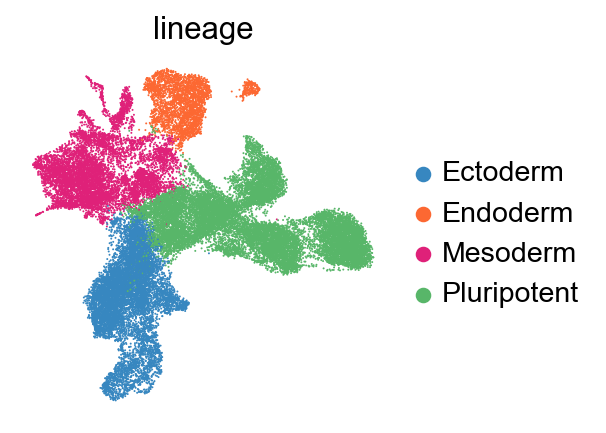

In [19]:
sc.pl.umap(adata_ref, color="lineage")

/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_64575/215457129.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['lineage'] = adata.obs['germlayer']
/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


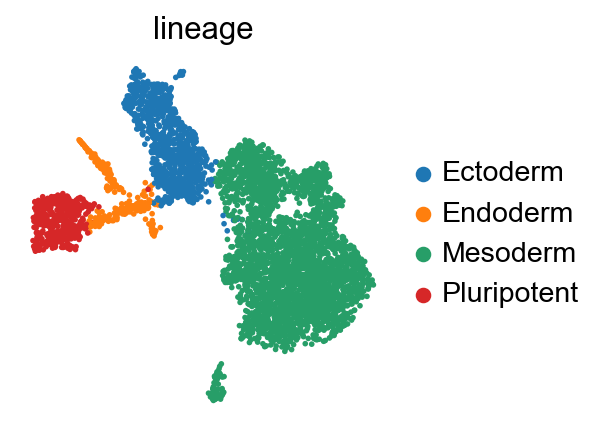

In [20]:
adata.obs['lineage'] = adata.obs['germlayer']
adata.obs['lineage'] = [sub.replace('Pluripotency', 'Pluripotent') for sub in adata.obs['lineage']]
sc.pl.umap(adata, color="lineage" )

### Mapping labels using ingest

Let's map labels and embeddings from `adata_ref` to `adata` based on a chosen representation. Here, we use `adata_ref.obsm['X_pca']` to map cluster labels and the UMAP coordinates.

In [21]:
sc.tl.ingest(adata, adata_ref, obs=["lineage","pseudotime",'hour'])

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


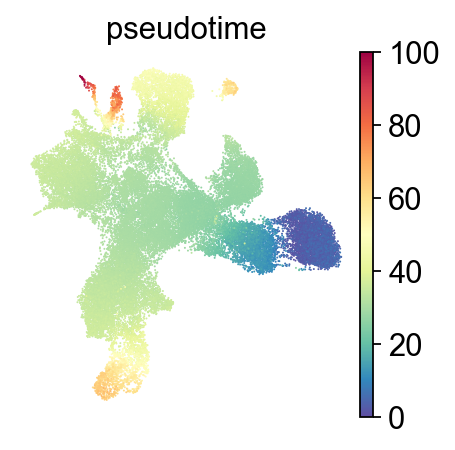

In [22]:
sc.pl.umap(adata_ref, color=["pseudotime"], cmap = 'Spectral_r',palette = 'Spectral_r',wspace=0.5)

In [23]:
adata.uns["lineage_colors"] = adata_ref.uns["lineage_colors"]  # fix colors
adata.uns["hour_colors"] = adata_ref.uns["hour_colors"]  # fix colors
adata.obs['pseudotime'] = adata.obs['pseudotime'].astype('float')
#adata.uns["pseudotime_colors"] = adata_ref.uns["pseudotime_colors"]  # fix colors

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


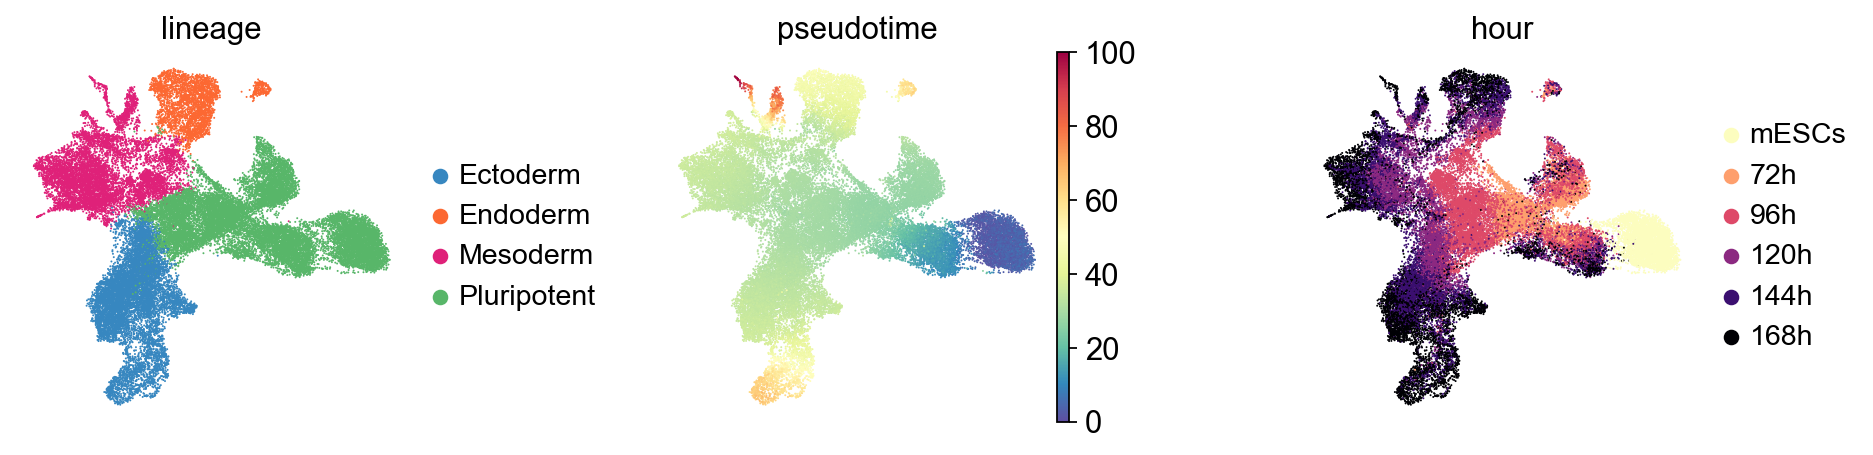

In [24]:
sc.pl.umap(adata_ref, color=["lineage","pseudotime",'hour'],cmap = 'Spectral_r', wspace=0.5)

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


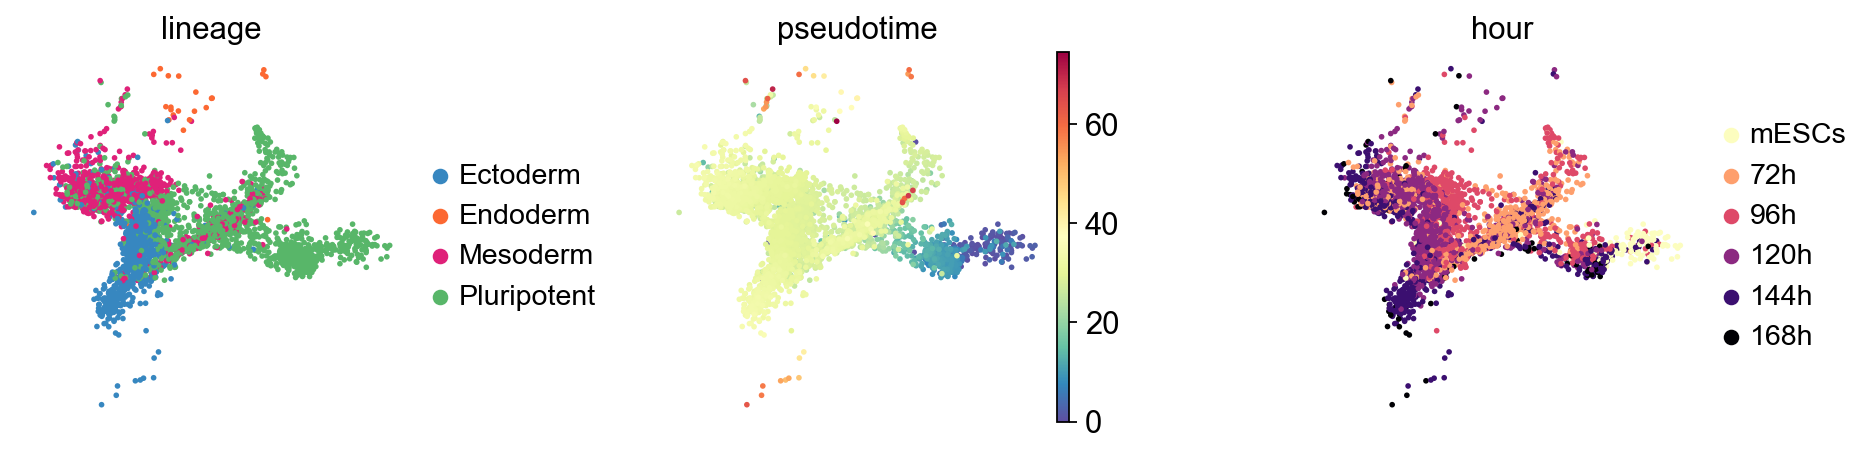

In [25]:
sc.pl.umap(adata, color=["lineage","pseudotime",'hour'],cmap = 'Spectral_r', wspace=0.5)

In [26]:
adata_concat = adata_ref.concatenate(adata, batch_categories=["tchic", "preculture"])

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [29]:
import seaborn as sns
sns.color_palette("Set3",6)

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961)]

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


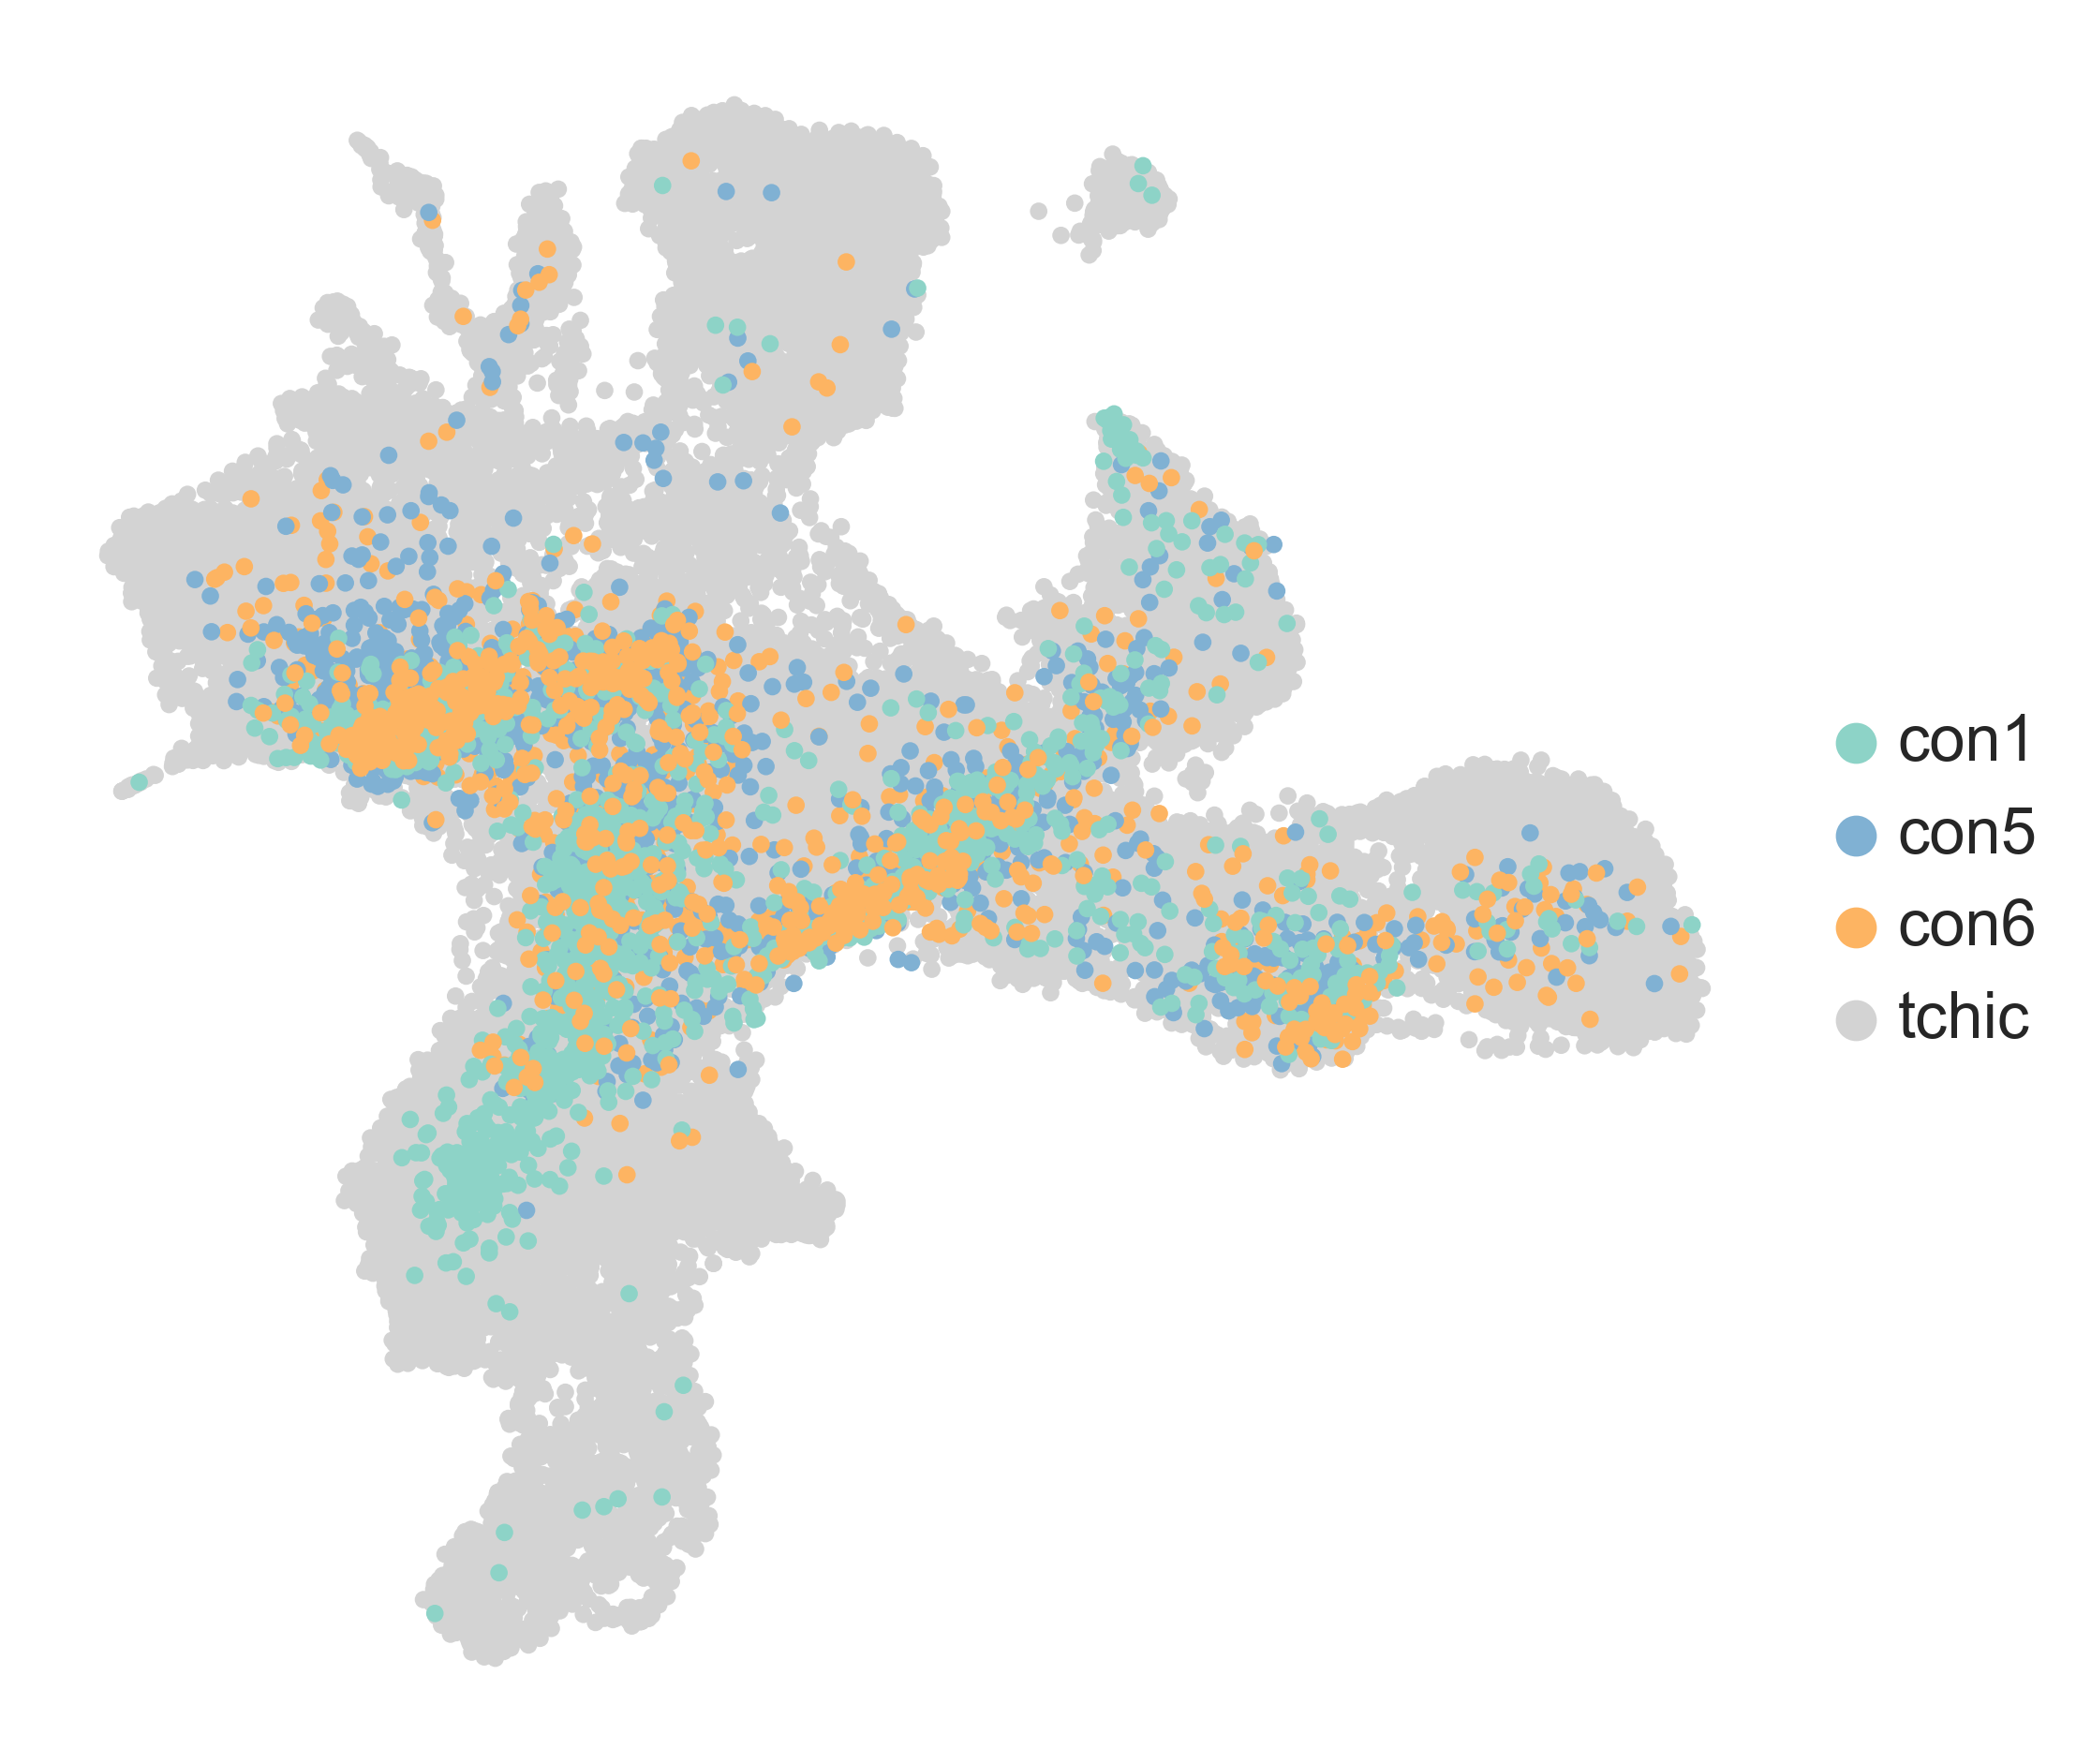

In [116]:
fig,ax = plt.subplots(figsize=(8,8))

sc.pl.umap(adata_concat, color=["condition"], ncols = 1, palette = [sns.color_palette("Set3",6)[0],
                                                                    sns.color_palette("Set3",6)[4],
                                                                    sns.color_palette("Set3",6)[5],
                                                                    'lightgrey'], ax=ax,title = '',frameon = False,
           save = 'umap_tchic_projection.png',
          alpha = 1, size = 80)

In [99]:
sc.tl.embedding_density(adata_concat, groupby="condition")

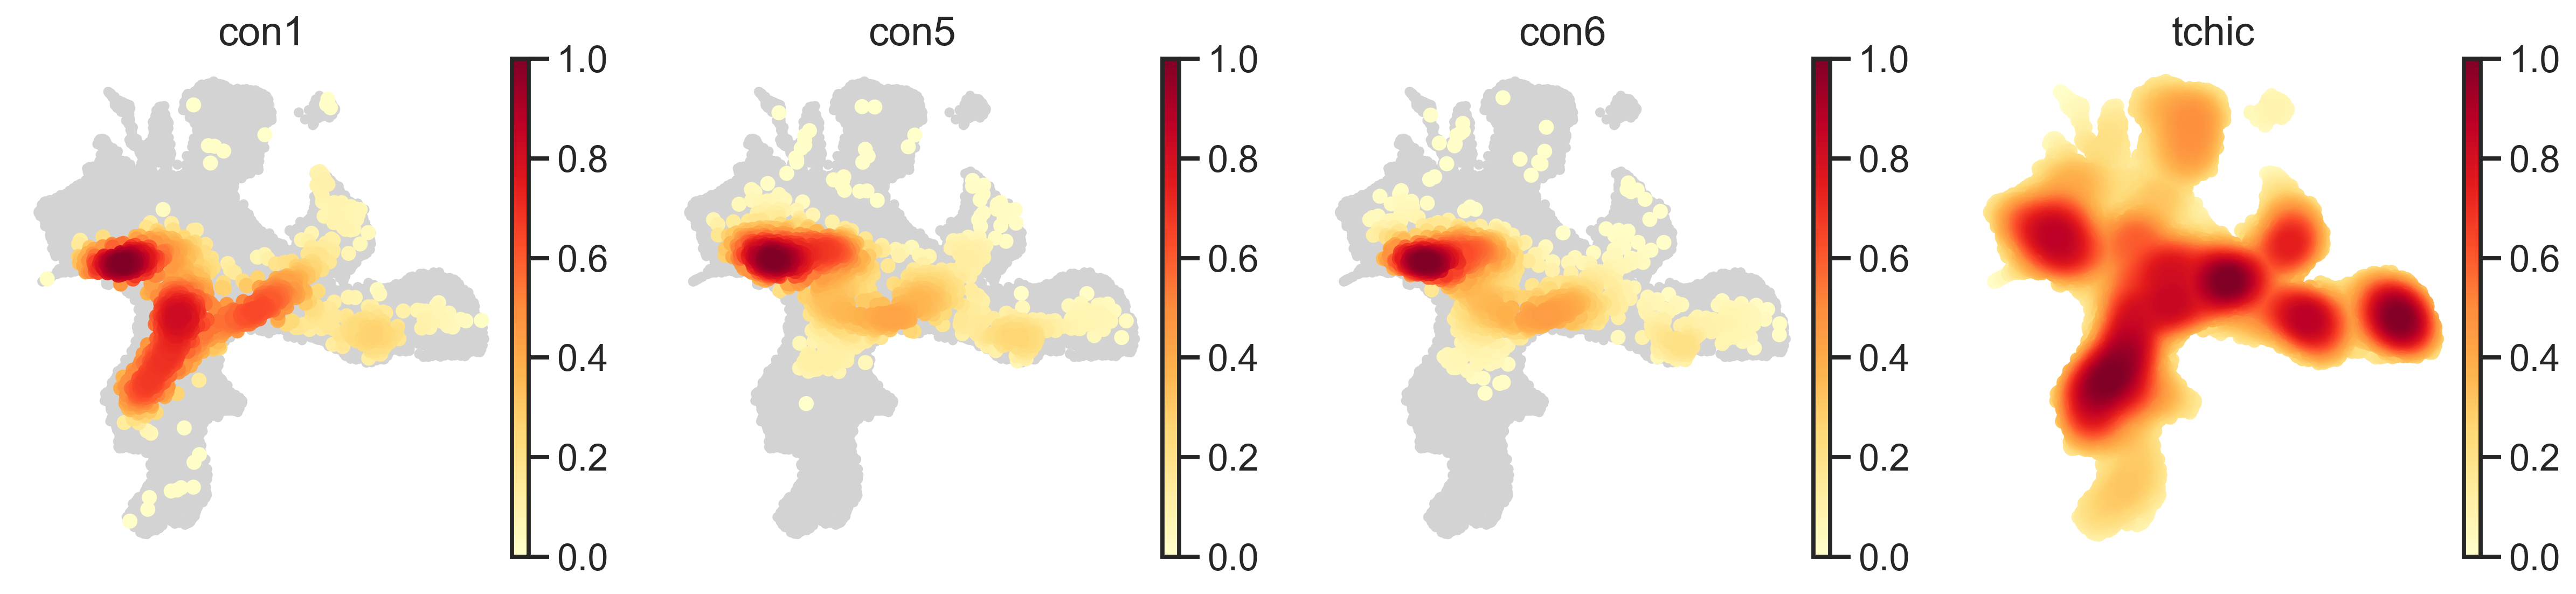

In [102]:
sc.pl.embedding_density(adata_concat, groupby="condition", frameon= False, save = 'umap_density.png')

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


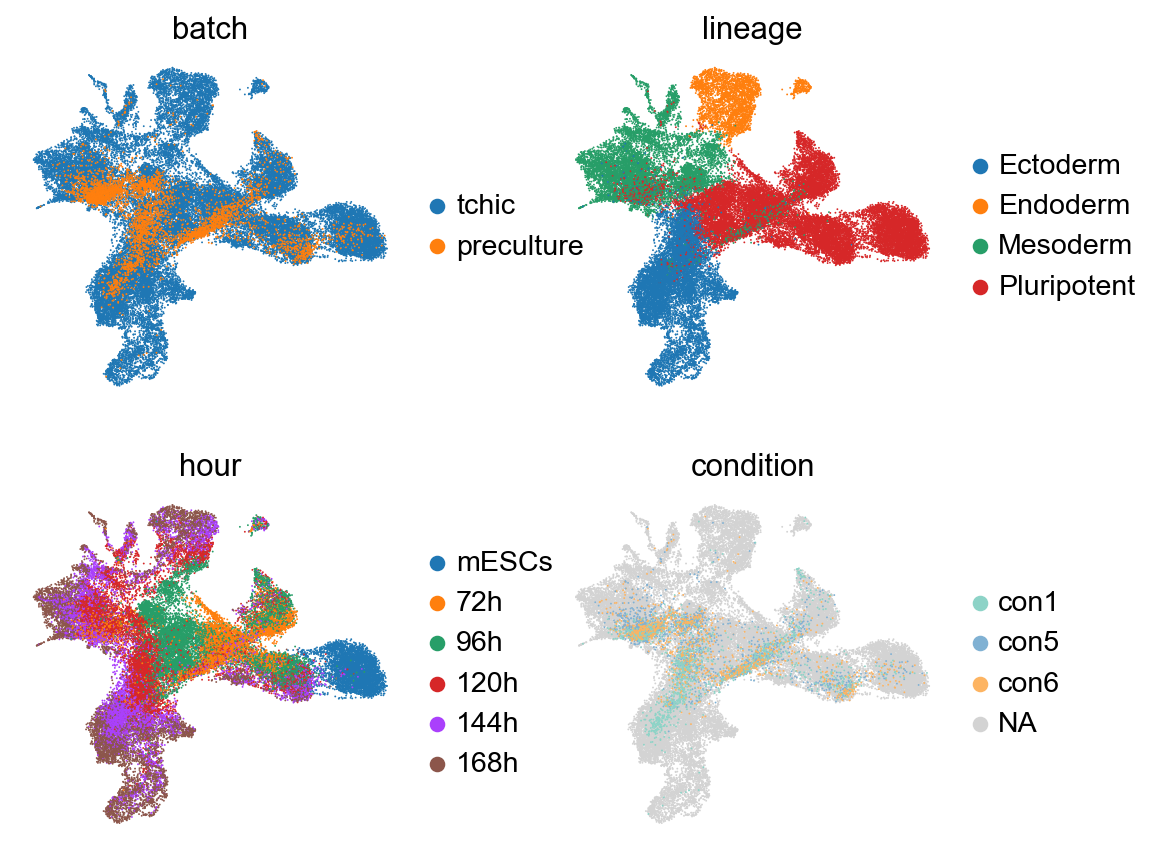

In [31]:
sc.pl.umap(adata_concat, color=["batch", "lineage", 'hour', 'condition'], ncols = 2)

In [33]:
adata_concat.obs['condition'] = adata_concat.obs['condition'].cat.add_categories("tchic").fillna("tchic")

In [34]:
adata_concat.obs['condition2'] = adata_concat.obs['condition']

In [35]:
adata_concat.obs['condition2']  = adata_concat.obs['condition2'].astype('str')

In [36]:
adata_concat.obs.loc[adata_concat.obs['day'] == 'mESCs', 'condition2'] = 'tchic_mESC'
adata_concat.obs.loc[adata_concat.obs['day'] == 'Gastd3', 'condition2'] = 'tchic_72h'
adata_concat.obs.loc[adata_concat.obs['day'] == 'Gastd4', 'condition2'] = 'tchic_96h'
adata_concat.obs.loc[adata_concat.obs['day'] == 'Gastd5', 'condition2'] = 'tchic_120h'
adata_concat.obs.loc[adata_concat.obs['day'] == 'Gastd6', 'condition2'] = 'tchic_144h'
adata_concat.obs.loc[adata_concat.obs['day'] == 'Gastd7', 'condition2'] = 'tchic_168h'

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


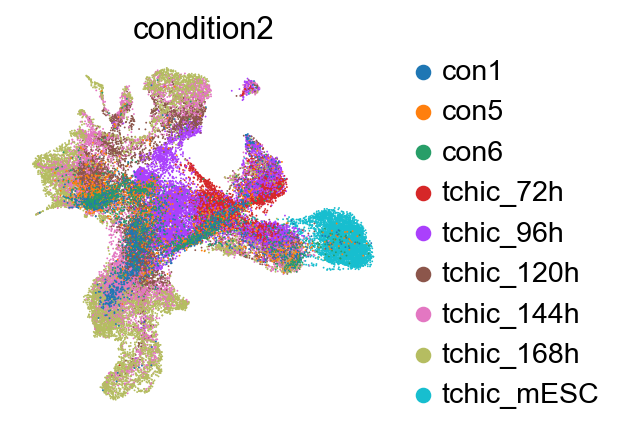

In [37]:
sc.pl.umap(adata_concat, color = 'condition2')

In [41]:
order = ['tchic_mESC',
    'tchic_72h',
    'tchic_96h','con1','con5','con6',
             'tchic_120h', 
         'tchic_144h', 'tchic_168h' ]



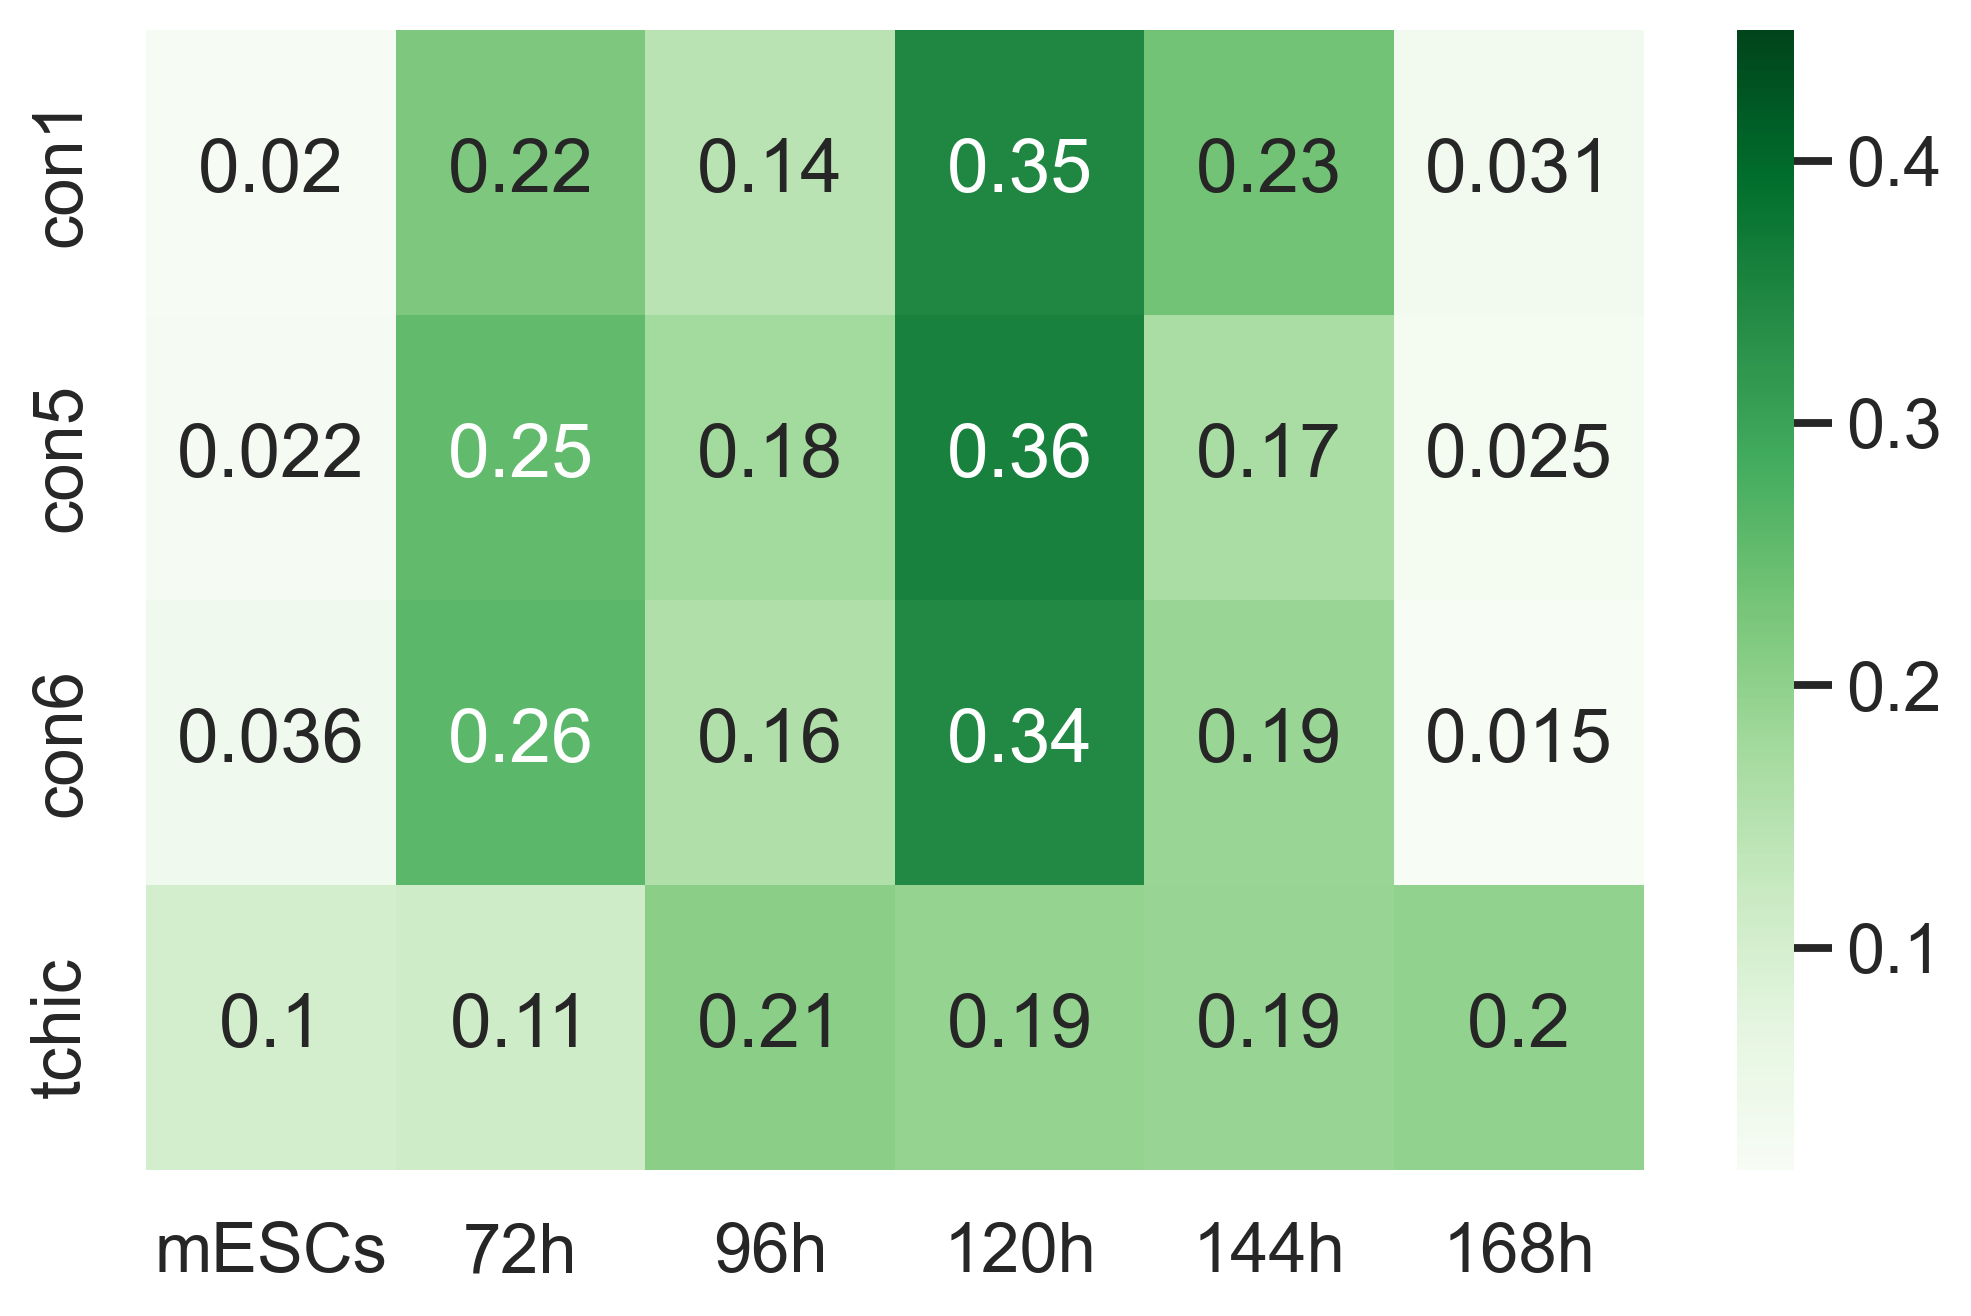

In [106]:
import matplotlib.pyplot as plt
sns.set_style('white')
fig,ax=plt.subplots(figsize = (8,5))
sns.heatmap(pd.crosstab(adata_concat.obs['condition'],adata_concat.obs['hour'], normalize='index'),#.loc[order], 
            annot = True, ax=ax, cmap = 'Greens', vmax = 0.45)
plt.ylabel('')
plt.xlabel('')
plt.savefig('figures/pseudotime_heatmap_ratios_tp.png', dpi = 300, bbox_inches = 'tight')

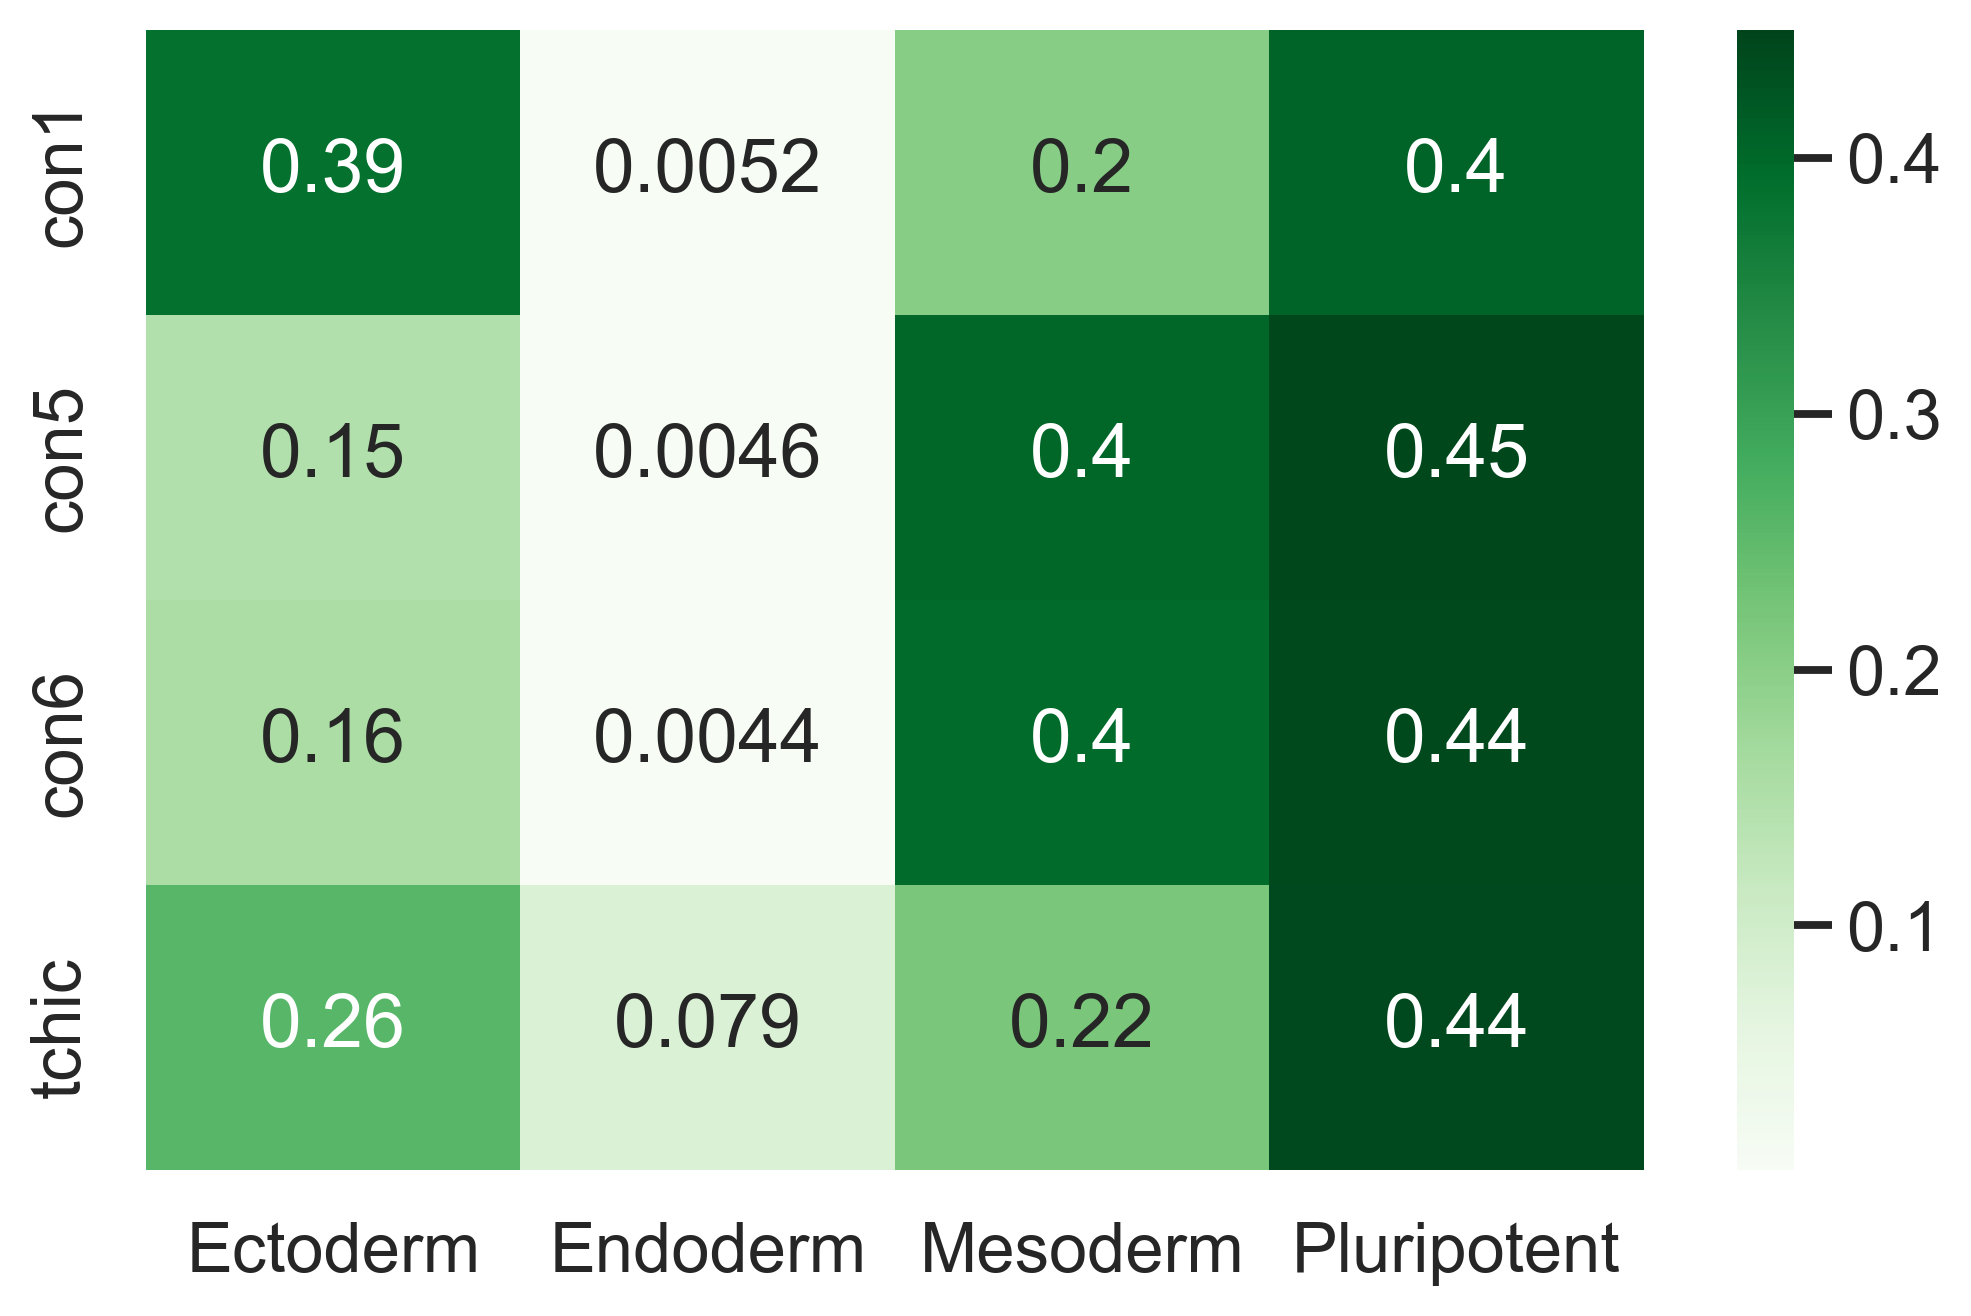

In [104]:
import matplotlib.pyplot as plt
sns.set_style('white')
fig,ax=plt.subplots(figsize = (8,5))
sns.heatmap(pd.crosstab(adata_concat.obs['condition'],adata_concat.obs['lineage'], normalize='index'),#.loc[order],
            annot = True, ax=ax, cmap = 'Greens', vmax = 0.45)
plt.ylabel('')
plt.xlabel('')
plt.savefig('figures/pseudotime_heatmap_ratios_lins.png', dpi = 300, bbox_inches = 'tight')

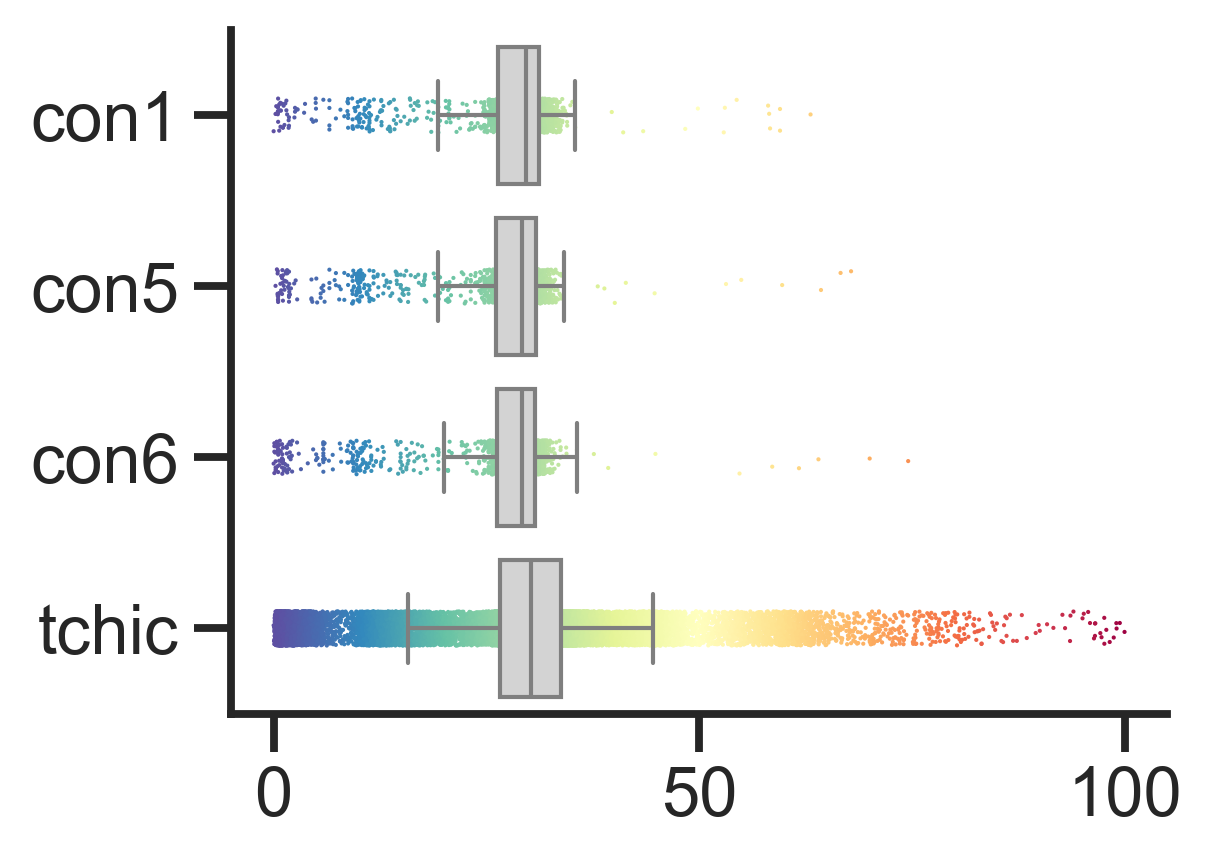

In [115]:
sc.set_figure_params(dpi=150)
pseudotime = adata_concat.obs[['pseudotime','condition2','condition','hour','lineage']]
sns.set_style('white')
sns.set_context('talk')
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(4,3))

sns.stripplot(data=pseudotime,ax=ax,
               y = 'condition',
               x = 'pseudotime',zorder = 0,
             hue = 'pseudotime',#order=order,
              size = 1,
             palette = 'Spectral_r')
sns.boxplot(data=pseudotime,ax=ax,
               y = 'condition',
               x = 'pseudotime',#order=order,
             color = 'lightgrey',fliersize = 0)
sns.despine()
#plt.axvline(30, color = 'black', lw = 1, ls = '--',)
plt.legend([],frameon=False)
plt.ylabel('')
plt.xlabel('')
plt.savefig('figures/boxplot_pseudotime.png', dpi = 300, bbox_inches = 'tight')

In [60]:
from scipy import stats

condition = ['con5','con6','tchic']

for  con in condition:
    print(con)
    stat1 = stats.mannwhitneyu(x=pseudotime[pseudotime['condition'] == 'con1']['pseudotime'],
                   y=pseudotime[pseudotime['condition'] == con]['pseudotime'],
                   alternative = 'two-sided')
    if stat1[1] < 5.00e-02:
        print(stat1)
        print('*')
    if stat1[1] < 1.00e-03:   
        print('**')
    

con5
MannwhitneyuResult(statistic=1290277.5, pvalue=1.1157062465877114e-06)
*
**
con6
MannwhitneyuResult(statistic=1346554.0, pvalue=1.395553471079247e-08)
*
**
tchic
MannwhitneyuResult(statistic=24225777.0, pvalue=4.0789851551923214e-29)
*
**


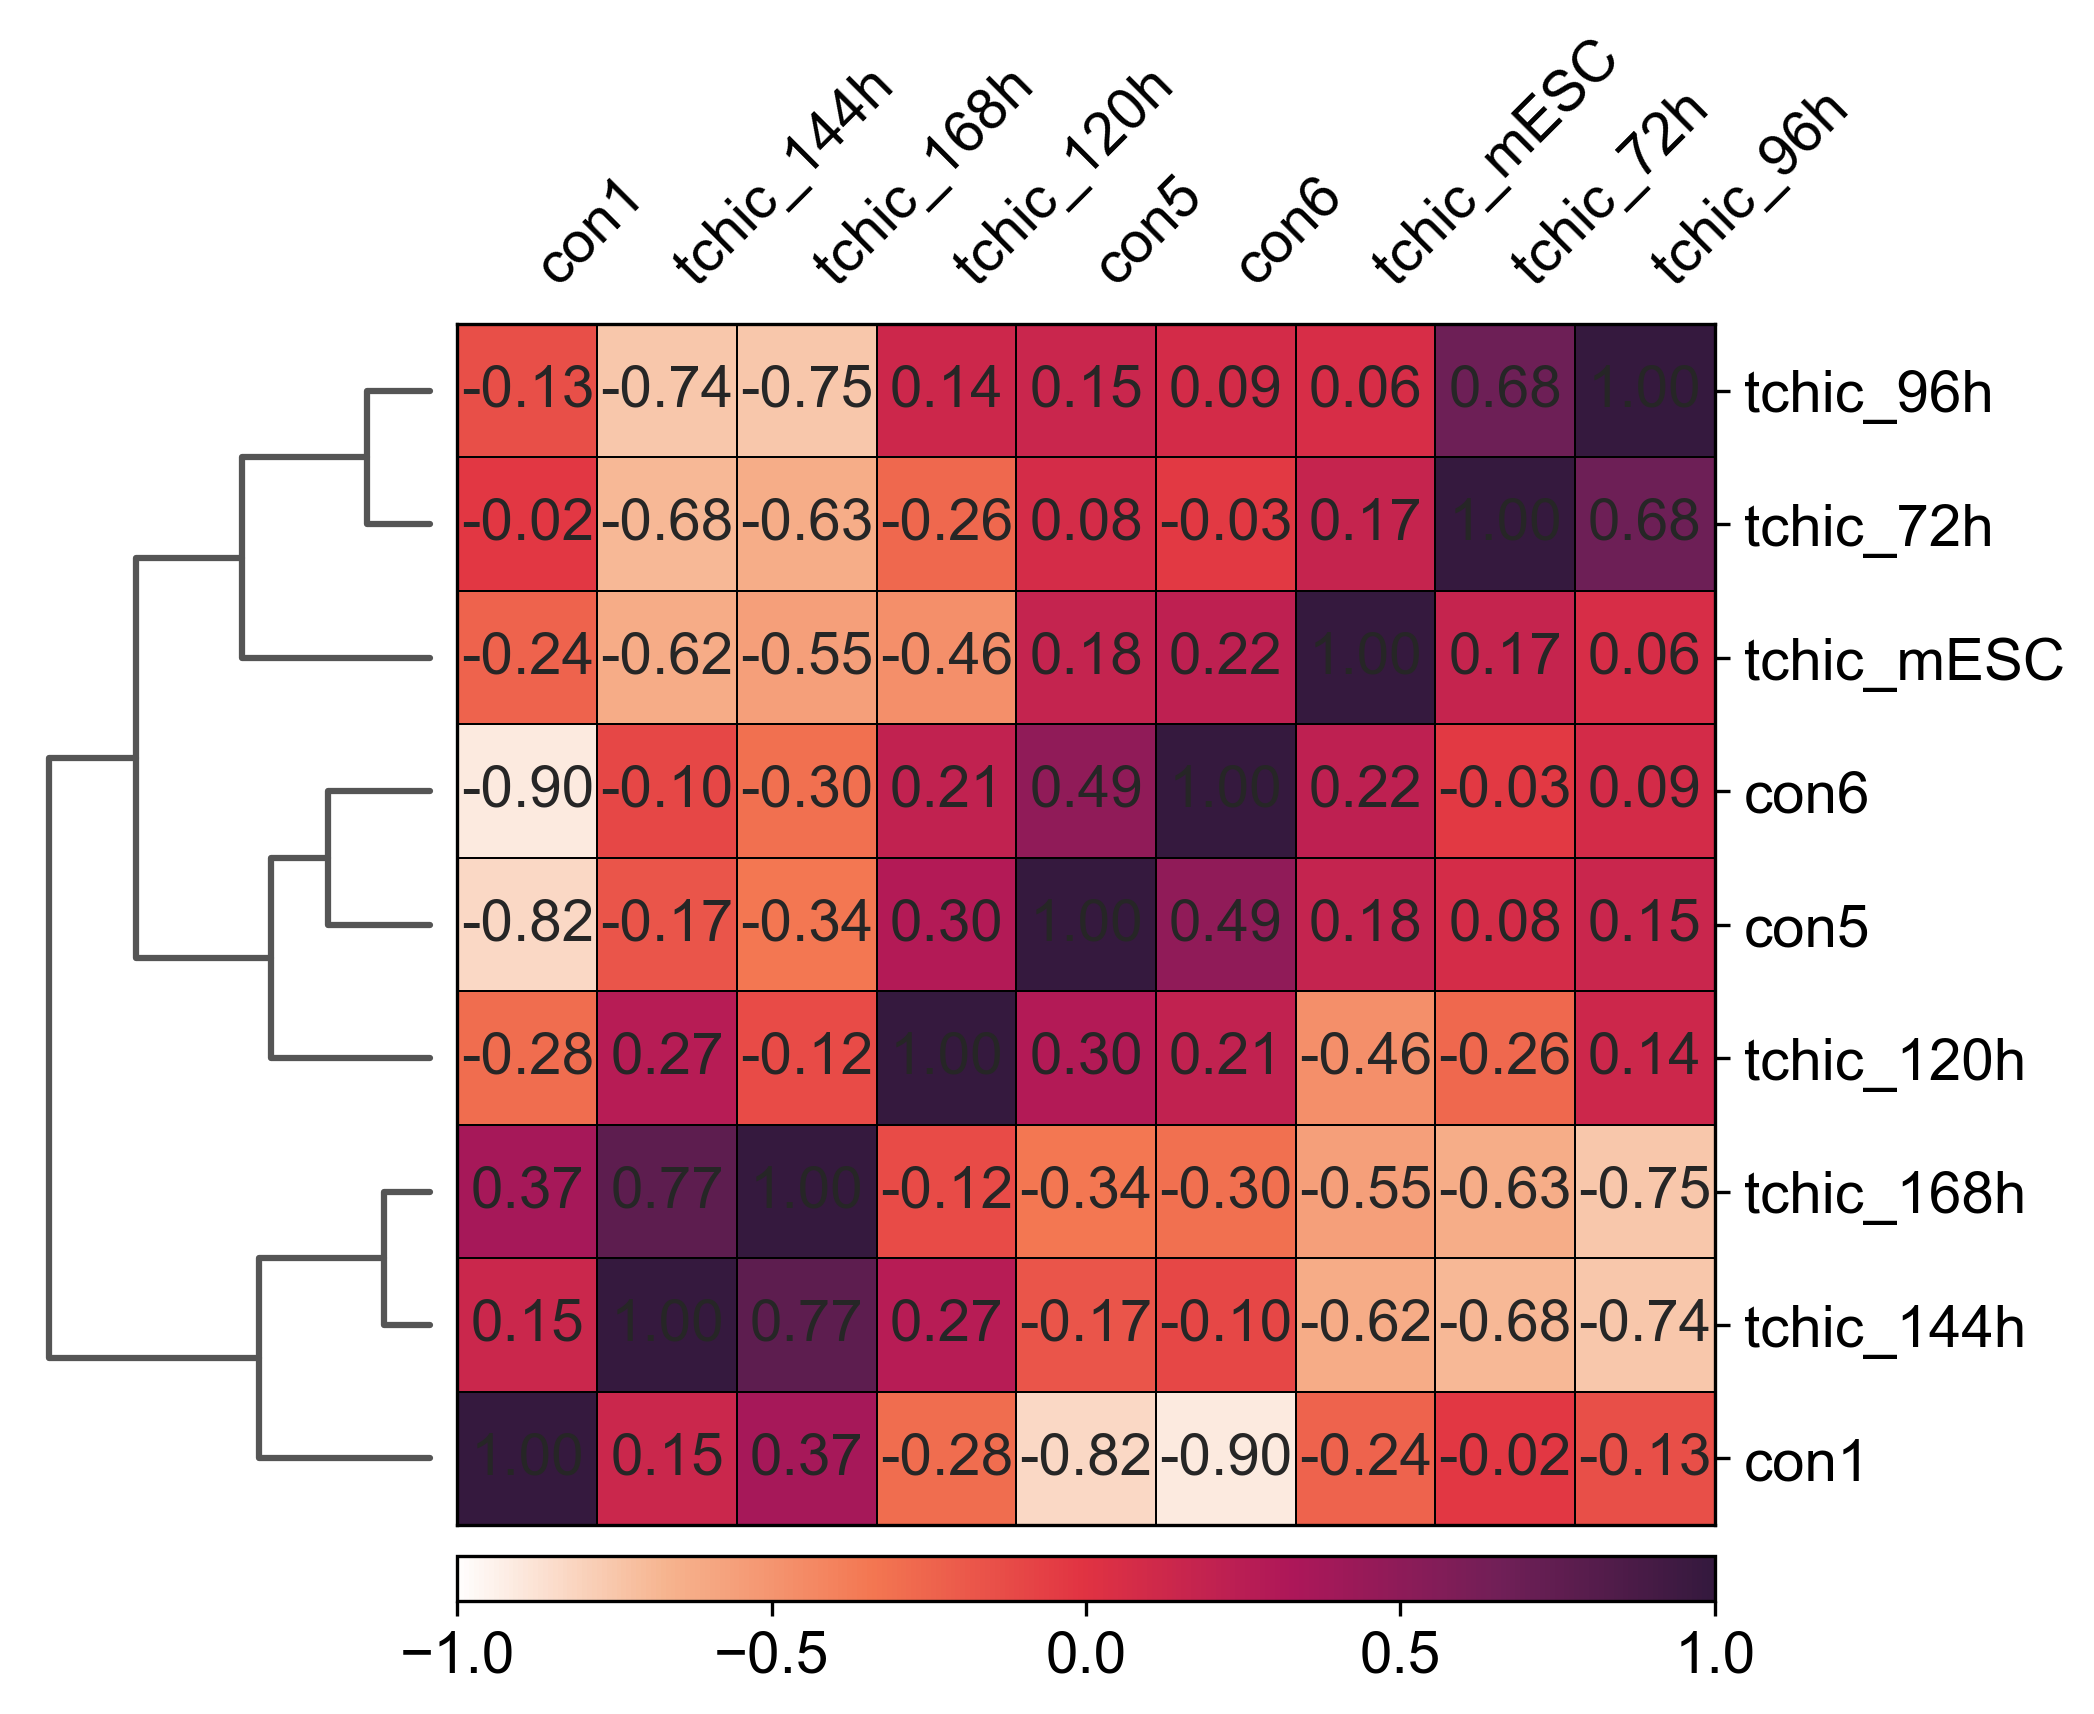

In [45]:
test_palette = sns.blend_palette(["white",'#f6b48f', '#f37651', '#e13342', '#ad1759', '#701f57', '#35193e'], as_cmap=True)
sc.tl.dendrogram(adata_concat,"condition2", cor_method='pearson')
ax = sc.pl.correlation_matrix(adata_concat, 'condition2', cmap=test_palette,show_correlation_numbers=True)#  dendrogram=True)
